In [13]:
import torch
from torch import Tensor
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import time, copy

from utils_mnist import *

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device: {torch.cuda.get_device_name(0)}")

Using cuda device: Tesla T4


In [15]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # EfficientNet requires inputs of size 224x224
    transforms.Grayscale(num_output_channels=3),  # Convert MNIST images to three-channel images
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [16]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [17]:
classes = train_data.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [18]:
train_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [19]:
print(train_data.data.shape)
print(type(train_data.data))
print(type(train_data))

torch.Size([60000, 28, 28])
<class 'torch.Tensor'>
<class 'torchvision.datasets.mnist.MNIST'>


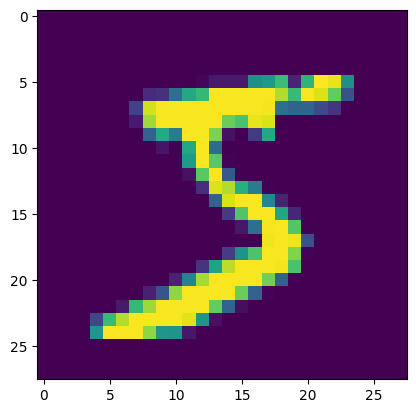

In [20]:
plt.imshow(train_data.data[0])
im,label = next(iter(train_loader))

In [21]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

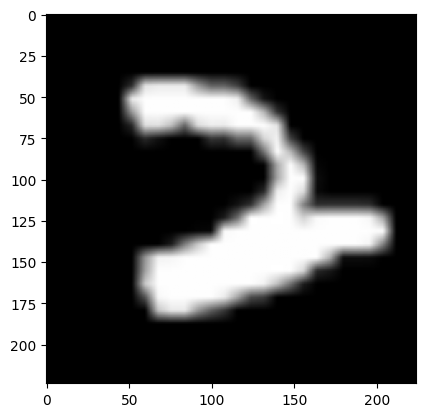

In [22]:
im[0].shape
imshow(im[0])

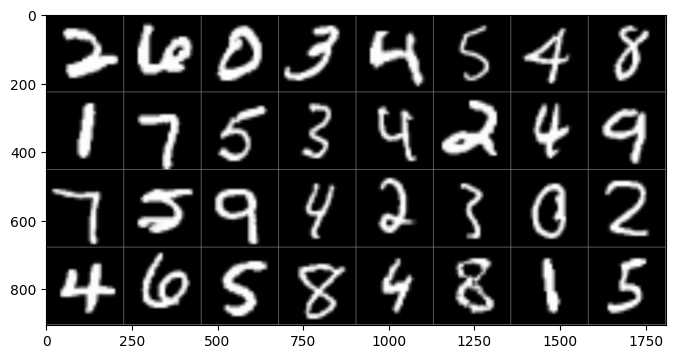

In [23]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

In [24]:
from math import ceil
basic_mb_params = [
    # k, channels(c), repeats(t), stride(s), kernel_size(k)
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

alpha, beta = 1.2, 1.1

scale_values = {
    # (phi, resolution, dropout)
    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, padding, groups=1):
        super(ConvBlock, self).__init__()
        self.cnnblock = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size,
                                  stride, padding, groups=groups),
                        nn.BatchNorm2d(out_channels),
                        nn.SiLU())

    def forward(self, x):
        return self.cnnblock(x)

class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)

class MBBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
        stride, padding, ratio, reduction=2,
    ):
        super(MBBlock, self).__init__()
        # self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * ratio
        self.expand = in_channels != hidden_dim

        # This is for squeeze and excitation block
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = ConvBlock(in_channels, hidden_dim,
                kernel_size=3,stride=1,padding=1)

        self.conv = nn.Sequential(
                ConvBlock(hidden_dim,hidden_dim,kernel_size,
                  stride,padding,groups=hidden_dim),
                SqueezeExcitation(hidden_dim, reduced_dim),
                nn.Conv2d(hidden_dim, out_channels, 1),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, inputs):
        if self.expand:
          x = self.expand_conv(inputs)
        else:
          x = inputs
        return self.conv(x)

class EfficientNet(nn.Module):
    def __init__(self, model_name, output):
        super(EfficientNet, self).__init__()
        phi, resolution, dropout = scale_values[model_name]
        self.depth_factor, self.width_factor = alpha**phi, beta**phi
        self.last_channels = ceil(1280 * self.width_factor)
        self.avgpool= nn.AdaptiveAvgPool2d(1)
        self.feature_extractor()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.last_channels, output),
        )

    def feature_extractor(self):
        channels = int(32 * self.width_factor)
        features = [ConvBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for k, c_o, repeat, s, n in basic_mb_params:
            # For numeric stability, we multiply and divide by 4
            out_channels = 4 * ceil(int(c_o * self.width_factor) / 4)
            num_layers = ceil(repeat * self.depth_factor)

            for layer in range(num_layers):
                if layer == 0:
                  stride = s
                else:
                  stride = 1
                features.append(
                        MBBlock(in_channels,out_channels,ratio=k,
                        stride=stride,kernel_size=n,padding=n// 2)
                    )
                in_channels = out_channels

        features.append(
            ConvBlock(in_channels, self.last_channels,
            kernel_size=1, stride=1, padding=0)
        )
        self.extractor = nn.Sequential(*features)

    def forward(self, x):
        x = self.avgpool(self.extractor(x))
        return self.classifier(self.flatten(x))

In [25]:
model_name = 'b0'
output_class = 10 #for imagenet
model = EfficientNet(model_name, output_class).to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# train_function(model, optimizer, criterion, epochs=num_epochs, model_save_path="outputs/effnetb1_mnist.pth")

In [27]:
num_epochs = 20
train_losses = []
train_accuracies = []
test_accuracies = []

In [28]:
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU or CPU

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_loss)
    train_accuracies.append(train_accuracy)
    print(f'Epoch {epoch+1} Loss: {epoch_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Test the model
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU or CPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)
    print(f'Test Accuracy: {test_accuracy:.2f}%')

Epoch 1 Loss: 0.2163, Train Accuracy: 93.51%
Test Accuracy: 97.36%
Epoch 2 Loss: 0.0826, Train Accuracy: 97.64%
Test Accuracy: 98.69%
Epoch 3 Loss: 0.0658, Train Accuracy: 98.18%
Test Accuracy: 98.79%
Epoch 4 Loss: 0.0555, Train Accuracy: 98.44%
Test Accuracy: 98.75%
Epoch 5 Loss: 0.0463, Train Accuracy: 98.71%
Test Accuracy: 98.91%
Epoch 6 Loss: 0.0389, Train Accuracy: 98.91%
Test Accuracy: 98.99%
Epoch 7 Loss: 0.0359, Train Accuracy: 99.00%
Test Accuracy: 99.04%
Epoch 8 Loss: 0.0317, Train Accuracy: 99.10%
Test Accuracy: 99.52%
Epoch 9 Loss: 0.0294, Train Accuracy: 99.18%
Test Accuracy: 99.38%
Epoch 10 Loss: 0.0234, Train Accuracy: 99.32%
Test Accuracy: 99.28%
Epoch 11 Loss: 0.0223, Train Accuracy: 99.37%
Test Accuracy: 99.35%
Epoch 12 Loss: 0.0204, Train Accuracy: 99.39%
Test Accuracy: 99.39%
Epoch 13 Loss: 0.0181, Train Accuracy: 99.47%
Test Accuracy: 99.14%
Epoch 14 Loss: 0.0189, Train Accuracy: 99.46%
Test Accuracy: 99.41%
Epoch 15 Loss: 0.0154, Train Accuracy: 99.58%
Test Accura

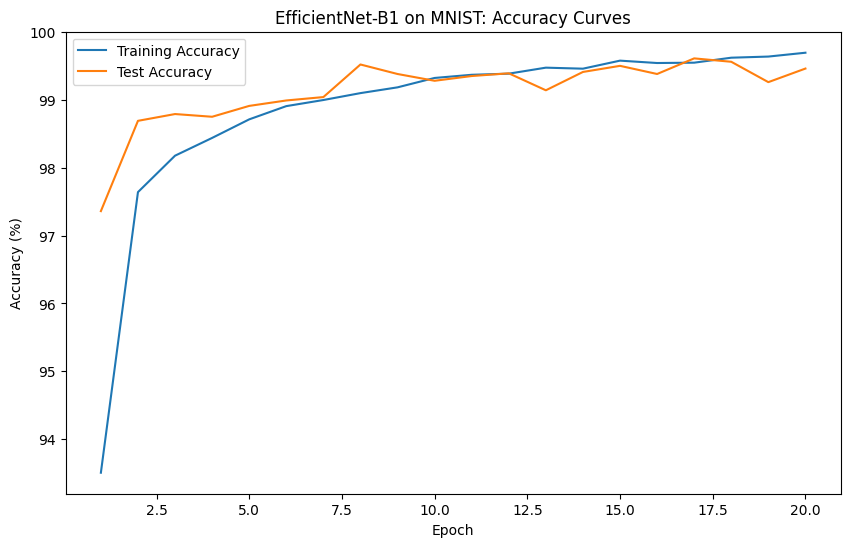

In [29]:
import matplotlib.pyplot as plt

# Plot the training and test accuracy curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('EfficientNet-B1 on MNIST: Accuracy Curves')
plt.legend()
plt.show()

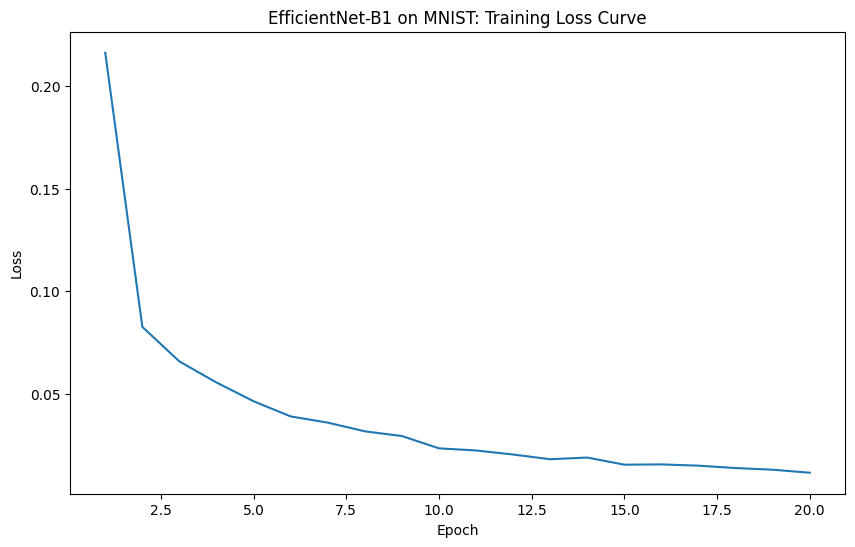

In [30]:

# Plot the training loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('EfficientNet-B1 on MNIST: Training Loss Curve')
plt.show()

In [34]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
testloader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True, num_workers=0)
model.eval()
for data in testloader: # Loop through each batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    model.eval() # Convert the model to test mode
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = model(images) # Enter the network for testing

    # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0) # update the number of test images
    correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 99.46 %


In [35]:
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
model.eval()
with torch.inference_mode():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of 0 - zero : 99.90 %
Accuracy of 1 - one : 99.82 %
Accuracy of 2 - two : 99.90 %
Accuracy of 3 - three : 100.00 %
Accuracy of 4 - four : 99.29 %
Accuracy of 5 - five : 98.65 %
Accuracy of 6 - six : 98.54 %
Accuracy of 7 - seven : 99.22 %
Accuracy of 8 - eight : 99.59 %
Accuracy of 9 - nine : 99.50 %


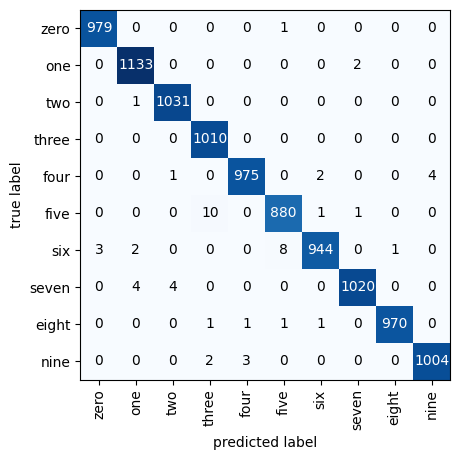

In [36]:
import numpy as np
from itertools import product


class_dict = {0: 'zero',
              1: 'one',
              2: 'two',
              3: 'three',
              4: 'four',
              5: 'five',
              6: 'six',
              7: 'seven',
              8: 'eight',
              9: 'nine'}

mat = compute_confusion_matrix(model=model.cpu(), data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 100.0%


<Figure size 2500x400 with 0 Axes>

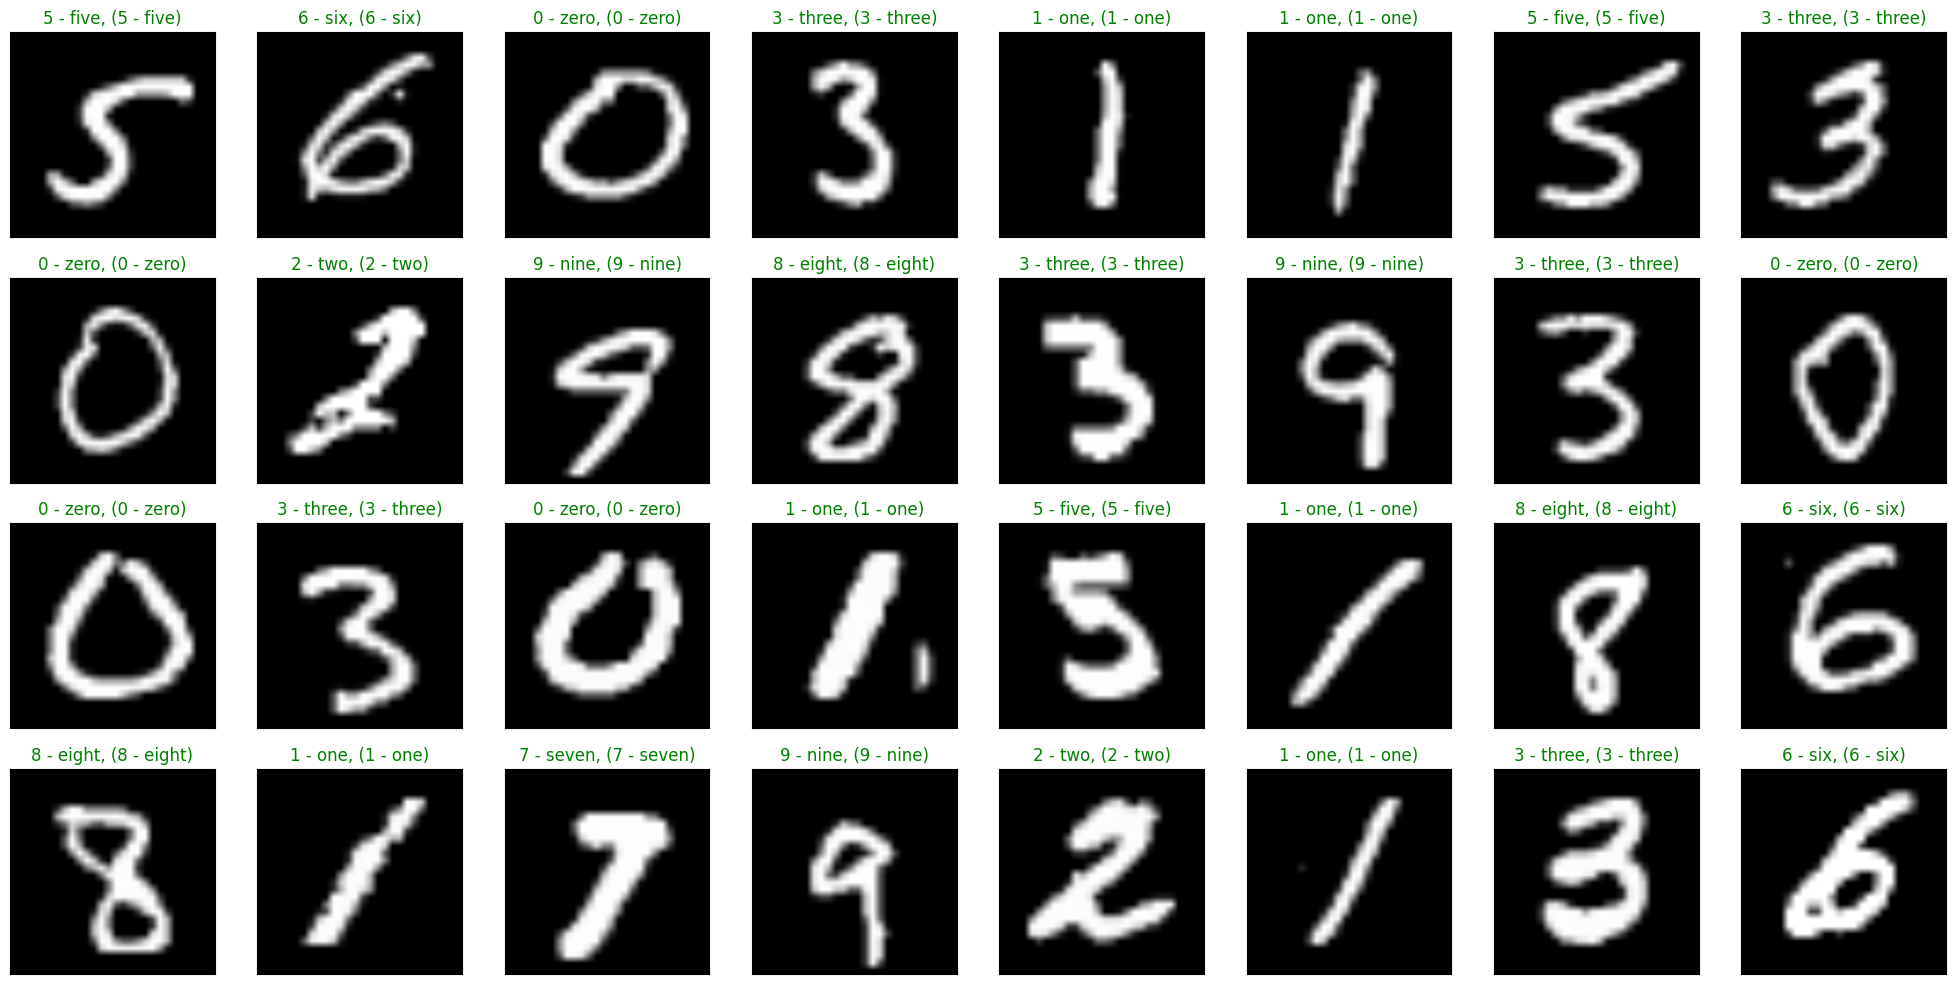

In [37]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to('cpu')
labels = labels.to('cpu')
val_output = model(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]),
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

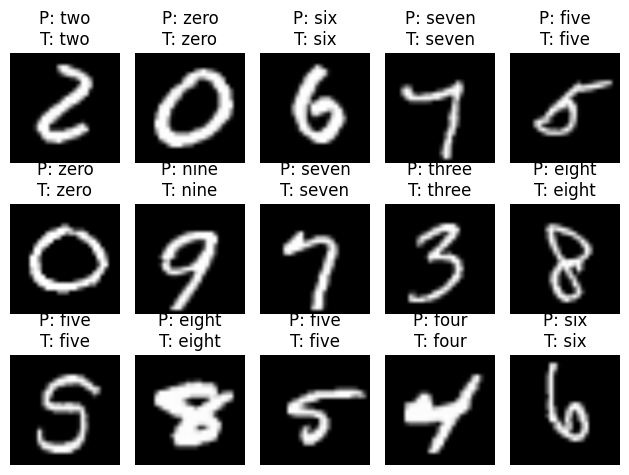

In [38]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)